In [1]:
import function as game
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import doctest

In [2]:
# simulat the game with 2 players and each player has 5 dices
num_players = 5
num_dice = 5
times = 1000

In [3]:
# set the validation index
results = {}
first_players = {}
original = {key: 0 for key in range(1, 7)}
liar_player = {key :0 for key in range(num_players)}
quantity = list(range(1, (num_players * num_dice) + 1))  
face_value = list(range(1, 7))
data = [(q, f, 0, 0, 0) for q in quantity for f in face_value]
liar_occur_bid = pd.DataFrame(data,columns = ['quantity','face_value','times','valid_times','invalid_times'])
liar_result = {"valid":0, "invalid" :0}
for i in range(num_players):
    results[f"player{i}"] = 0
    first_players[f'player {i}'] = 0

In [4]:
#check if the bid is valid
def valid_bid(bids):
    """
    Check if the bid sequence is valid: at least one of quantity or face_value
    increases in every step.

    :param bids: List of bids, where each bid is [quantity, face_value].
    :return: True if all bids are valid, False otherwise.
    >>> bids = [[4, 1], [4, 2], [10, 5], [14, 5], [16, 4], [18, 4], [19, 4]]
    >>> valid_bid(bids)
    True
    >>> bids = [[4, 1], [4, 2], [10, 5], [9, 5], [16, 4], [18, 4], [19, 4]]
    >>> valid_bid(bids)
    False
    """
    is_increasing = True  
    for i in range(1, len(bids)):
        prev_quantity, prev_face_value = bids[i - 1]
        curr_quantity, curr_face_value = bids[i]
        if not (curr_quantity > prev_quantity or curr_face_value > prev_face_value):
            is_increasing = False
            break
    return is_increasing
doctest.testmod()

TestResults(failed=0, attempted=4)

In [5]:
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice)

    #check if the bid is valid 
    for bid in bid_record:
        bids = []
        for player, action in bid.items():
            if action == 'liar':
                if valid_bid(bids):
                    pass 
                else:
                    print("There are invalid bid exists")
            else:
                bids.append(action)

    #record the winner and the first player distribution
    results[f"player{winner}"] += 1
    first_players[f"player {first_player}"] += 1
    
    #record the original dice distribution
    for key, values in original_dices.items():
        original[key] += values

    #record the liar call results
    for i in range(len(liar_record)):
        bid_times,current_player,challenge_bid,result,active_players = liar_record[i]
        if result == "valid":
            liar_result['valid']  += 1 
        else:
            liar_result['invalid'] += 1
        liar_player[current_player] += 1
        quantity, face_value = challenge_bid
        index = liar_occur_bid[(liar_occur_bid['quantity'] == quantity) & (liar_occur_bid['face_value'] == face_value)].index
        liar_occur_bid.loc[index,'times'] += 1
        if result == "valid":
            liar_occur_bid.loc[index,'valid_times'] += 1 
        else:
            liar_occur_bid.loc[index,'invalid_times'] += 1         

In [6]:
#check if the original dices are random
df = pd.DataFrame(list(original.items()), columns=["Face_value", "Occurrence"])
df['Occurrence rate'] = df['Occurrence'] / (times * num_players * num_dice)
df["Occurrence rate"] = df["Occurrence rate"].apply(lambda x: f"{x:.2%}") 
df

,Face_value,Occurrence,Occurrence rate
0,1,4143,16.57%
1,2,4117,16.47%
2,3,4112,16.45%
3,4,4247,16.99%
4,5,4183,16.73%
5,6,4198,16.79%


In [7]:
# check if everyone's win rate is equal 
win_rate_df = pd.DataFrame(list(results.items()), columns=["Player", "Wins"])
win_rate_df['Win Rate'] = win_rate_df['Wins'] / times
win_rate_df["Win Rate"] = win_rate_df["Win Rate"].apply(lambda x: f"{x:.2%}") 
win_rate_df

,Player,Wins,Win Rate
0,player0,207,20.70%
1,player1,186,18.60%
2,player2,215,21.50%
3,player3,190,19.00%
4,player4,202,20.20%


In [8]:
#check if the first player is random
start_rate_df = pd.DataFrame(list(first_players.items()), columns=["Player", "Start times"])
start_rate_df['Start rate'] = start_rate_df['Start times'] / times
start_rate_df["Start rate"] = start_rate_df["Start rate"].apply(lambda x: f"{x:.2%}") 
start_rate_df

,Player,Start times,Start rate
0,player 0,188,18.80%
1,player 1,198,19.80%
2,player 2,185,18.50%
3,player 3,215,21.50%
4,player 4,214,21.40%


     quantity  face_value  times  valid_times  invalid_times
59         10           6    623          620              3
89         15           6    533          533              0
119        20           6    451          451              0
149        25           6    443          443              0
53          9           6     63           56              7
..        ...         ...    ...          ...            ...
148        25           5      0            0              0
145        25           2      0            0              0
146        25           3      0            0              0
1           1           2      0            0              0
0           1           1      0            0              0

[150 rows x 5 columns]


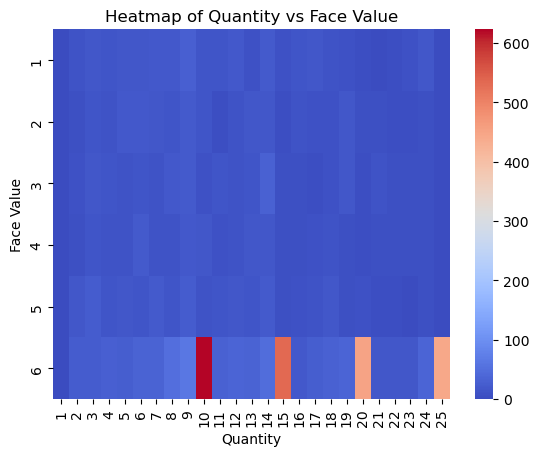

In [9]:
#check if the liar call is random 
liar_occur_bid = liar_occur_bid .sort_values(by='times', ascending=False)
print(liar_occur_bid)
#draw the heatmap of challenge_bid 
pivot_table = liar_occur_bid.pivot(index='face_value', columns='quantity', values='times')
sns.heatmap(pivot_table, annot=False, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Quantity vs Face Value")
plt.xlabel("Quantity")
plt.ylabel("Face Value")
plt.show()

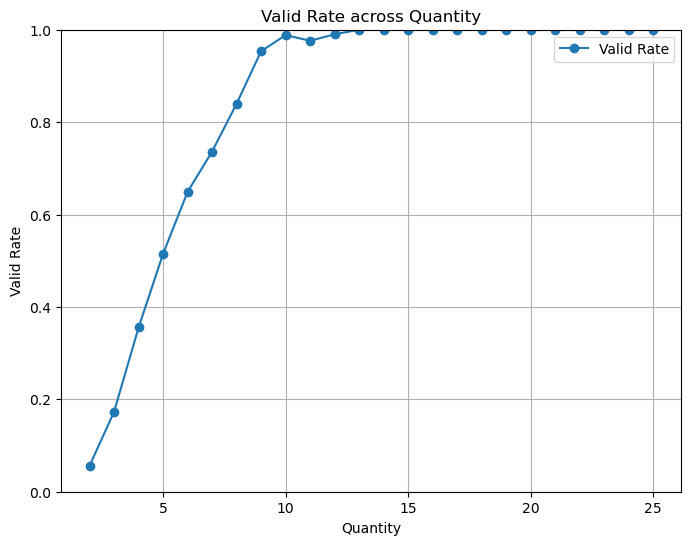

In [10]:
#check if with the quantity rasies, the valid rate increases,
#need to exclude the maxmum quantity matching the max_dices
grouped_liar = liar_occur_bid.groupby('quantity').agg({'times':'sum', 'valid_times':'sum', 'invalid_times':'sum'})
grouped_liar['valid_rate'] = grouped_liar['valid_times'] / grouped_liar['times']
grouped_liar
plt.figure(figsize=(8, 6))
plt.plot(grouped_liar.index, grouped_liar['valid_rate'], marker='o', label='Valid Rate')
plt.title("Valid Rate across Quantity")
plt.xlabel("Quantity")
plt.ylabel("Valid Rate")
plt.ylim(0, 1)  # Valid rate is a ratio (0 to 1)
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# check if the liar caller is random
print(liar_player)

{0: 813, 1: 762, 2: 813, 3: 822, 4: 790}
